# Unveiling Network Threats: Anomaly Detection in Intrusion Detection Systems

**Author:** Mário Antunes (mario.antunes@ua.pt)

**Date:** 24/11/2023

This notebook explores unsupervised methods to flag malicious packet flows.

The dataset was gathered by the [GCS](https://www.ua.pt/pt/ciberseguranca/sobre-gcs).


In [5]:
import gzip
import requests
import numpy as np
import polars as pl
import geopy.distance
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, f1_score
from imblearn.under_sampling import RandomUnderSampler

import keras
from tqdm.keras import TqdmCallback

import optuna
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Optuna imported and logging set.")

#plt.style.use('seaborn-v0_8-paper')
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['lines.linewidth'] = 2

# Color Blind adjusted colors and markers
colormap=['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
markers=['o', '*', '.', 'x', '+', 's', 'd', 'h', 'v']
lines=['-', ':', '--', '-.']

ModuleNotFoundError: No module named 'tensorflow'

## Load and Enhance the dataset. 

In [ ]:
f=gzip.open('../datasets/user-asn-sorted.csv.gz','rb')
file_content=f.read()
df = pl.read_csv(file_content, null_values=['-'])

df = df.with_columns(pl.col('timestamp').str.to_datetime('%Y-%m-%dT%H:%M:%S'))
df = df.drop('malware_type')
df.head()

timestamp,user,dst_port,asn,signature
datetime[μs],str,i64,i64,str
2023-10-03 16:00:00,"""0028e812""",443,15133,null
2023-10-03 16:00:00,"""0028e812""",443,15133,null
2023-10-03 16:00:00,"""0028e812""",443,15133,null
2023-10-03 16:00:00,"""0028e812""",443,15133,null
2023-10-03 16:00:00,"""0028e812""",443,54113,null


In [ ]:
signatures = df[['signature']].unique()['signature'].to_list()
dict_anomalies = {}
for k in signatures:
    if k is not None:
        dict_anomalies[k] = 1

df = df.with_columns(pl.col('signature').replace_strict(dict_anomalies, default=0).alias('anomaly'))
df = df.drop('signature')
df.head()

timestamp,user,dst_port,asn,anomaly
datetime[μs],str,i64,i64,i64
2023-10-03 16:00:00,"""0028e812""",443,15133,0
2023-10-03 16:00:00,"""0028e812""",443,15133,0
2023-10-03 16:00:00,"""0028e812""",443,15133,0
2023-10-03 16:00:00,"""0028e812""",443,15133,0
2023-10-03 16:00:00,"""0028e812""",443,54113,0


In [ ]:
r = requests.get('https://iptoasn.com/data/ip2asn-v4-u32.tsv.gz', headers={'User-agent': 'Mozilla/5.0'})
ASNs = pl.read_csv(r.content, separator='\t', has_header=False, new_columns=['start.ip','stop.ip','asn','country.code2','entity'])

#f=gzip.open('../datasets/ip2asn-v4-u32.tsv.gz','rb')
#file_content=f.read()
#ASNs = pl.read_csv(file_content, separator='\t', has_header=False, new_columns=['start.ip','stop.ip','asn','country.code2','entity'])

ASNs = ASNs.filter(pl.col('asn') != 0)
ASNs = ASNs[['asn','country.code2','entity']].unique()
ASNs.head()

asn,country.code2,entity
i64,str,str
61868,"""BR""","""NETFACIL INTERNET VIA RADIO E …"
272004,"""PE""","""EGP COMUNICACIONES S.A.C"""
58725,"""IN""","""ZYETELECOM-IN ZYE TELECOM PVT …"
45294,"""ID""","""WANXP-AS-ID PT. Wanriau Indoxp"""
18659,"""US""","""MERCHANT-SOLUTIONS-18659"""


In [ ]:
df = df.join(ASNs, on='asn')
df.head()

timestamp,user,dst_port,asn,anomaly,country.code2,entity
datetime[μs],str,i64,i64,i64,str,str
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST"""
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST"""
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST"""
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST"""
2023-10-03 16:00:00,"""0028e812""",443,54113,0,"""US""","""FASTLY"""


In [ ]:
countries = pl.read_csv('../datasets/countries_codes_and_coordinates.csv', null_values=['-'])
countries = countries.drop(['country.code3','country.code.num'])
countries.head()

country,country.code2,lat,lon
str,str,f64,f64
"""Afghanistan""","""AF""",33.0,65.0
"""Albania""","""AL""",41.0,20.0
"""Algeria""","""DZ""",28.0,3.0
"""American Samoa""","""AS""",-14.3333,-170.0
"""Andorra""","""AD""",42.5,1.6


In [ ]:
countries_list = countries.rows()
number_countries = len(countries_list)
countries_distance = np.zeros((number_countries, number_countries))

for i in range(number_countries-1):
    for j in range(i, number_countries):
        coords_1 = (countries_list[i][2], countries_list[i][3])
        coords_2 = (countries_list[j][2], countries_list[j][3])
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        countries_distance[i][j] = dist
        countries_distance[j][i] = dist

largest_distance = np.max(countries_distance)

np.fill_diagonal(countries_distance, largest_distance)

countries_distance

array([[20003.93145863,  4056.24098851,  5892.55181575, ...,
         2631.37442791,  6485.85247782,  6946.21012919],
       [ 4056.24098851, 20003.93145863,  2118.06012813, ...,
         3951.07919838,  6284.9146187 ,  6831.73234938],
       [ 5892.55181575,  2118.06012813, 20003.93145863, ...,
         4849.54132297,  5577.70272921,  6054.32061706],
       ...,
       [ 2631.37442791,  3951.07919838,  4849.54132297, ...,
        20003.93145863,  3864.23217398,  4343.86920757],
       [ 6485.85247782,  6284.9146187 ,  5577.70272921, ...,
         3864.23217398, 20003.93145863,   553.37666477],
       [ 6946.21012919,  6831.73234938,  6054.32061706, ...,
         4343.86920757,   553.37666477, 20003.93145863]], shape=(255, 255))

In [ ]:
countries_rank = [0] * number_countries

COUNTRY_IDX = 0
for i in range(number_countries):
    if countries_list[i][1] == 'PT':
        COUNTRY_IDX = i
        break
COUNTRY_IDX

rank = 0
processed_countries = [COUNTRY_IDX]
countries_rank[COUNTRY_IDX] = rank
rank += 1

In [ ]:
while len(processed_countries) < number_countries:
    distances = np.zeros(number_countries)
    for cidx in processed_countries:
        distances += countries_distance[cidx]
    COUNTRY_IDX = np.argmin(distances)

    while COUNTRY_IDX in processed_countries:
        distances[COUNTRY_IDX] = float('inf')
        COUNTRY_IDX = np.argmin(distances)

    processed_countries.append(COUNTRY_IDX)
    countries_rank[COUNTRY_IDX] = rank
    rank += 1

In [ ]:
map_contries = {}

for i in range(number_countries):
    map_contries[countries_list[i][0]] = countries_rank[i]


In [ ]:
map_dst_ports = {0:0, 1:0, 5:0,
7:10, 20:20, 21:20, 22:20, 23:20,
25:40, 37:10, 43:10, 53:10, 80:30,
81:50, 82:20, 83:0, 88: 20, 110:40,
119:40, 123:10, 135:10, 137:10, 139:10,
143:40, 161:10, 389:10, 443:30, 444:30, 445:20,
465:30, 500:10, 514:20, 585:40, 587:40, 843:10,
993:40, 995:40}

In [ ]:
df = df.join(countries, on='country.code2')
df = df.rename({'country.code2': 'country_code'})
df.head()

timestamp,user,dst_port,asn,anomaly,country_code,entity,country,lat,lon
datetime[μs],str,i64,i64,i64,str,str,str,f64,f64
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
2023-10-03 16:00:00,"""0028e812""",443,15133,0,"""US""","""EDGECAST""","""United States""",38.0,-97.0
2023-10-03 16:00:00,"""0028e812""",443,54113,0,"""US""","""FASTLY""","""United States""",38.0,-97.0


In [ ]:
users = ['0028e812', 'cb8f966a', '6b6e3de0', 'f80b9c1b', '769d71e8', 'cd46ec92', '03aec668']

connections = []

for u in users:
    single_user = df.filter(pl.col('user') == u)
    connections.append(single_user.rows(named=True))

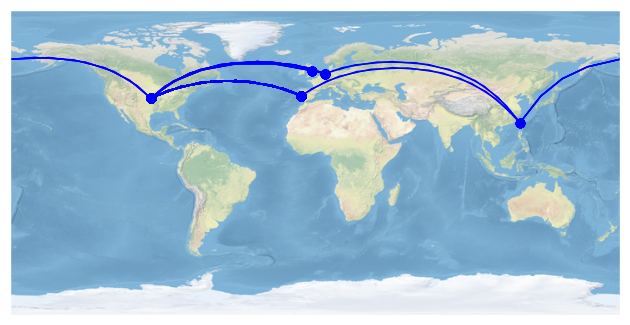

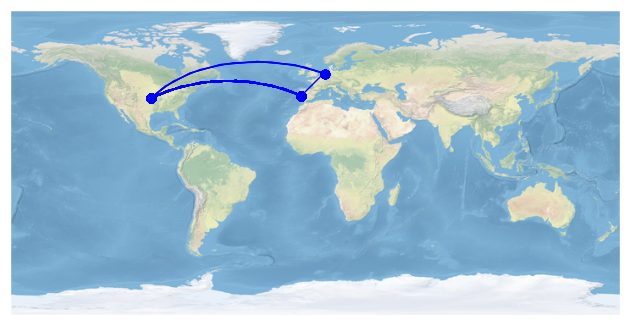

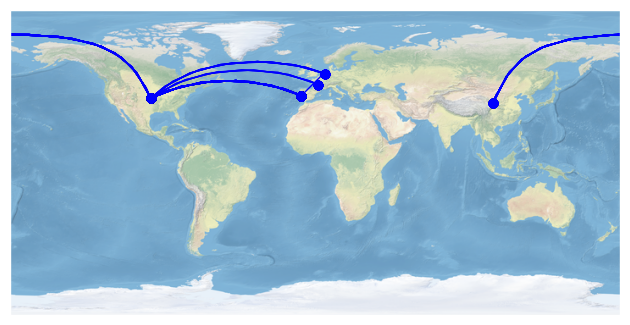

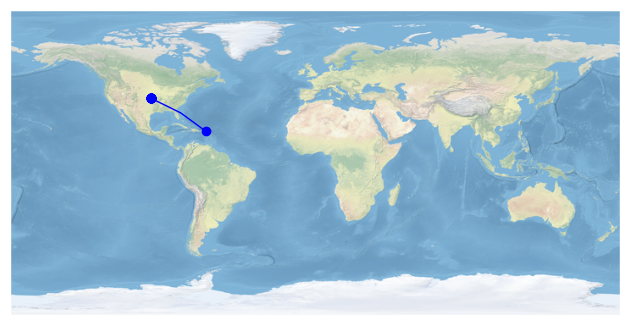

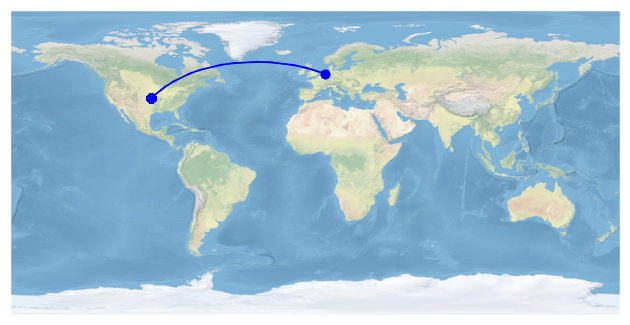

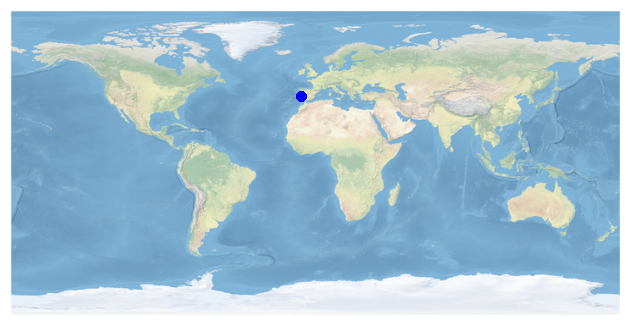

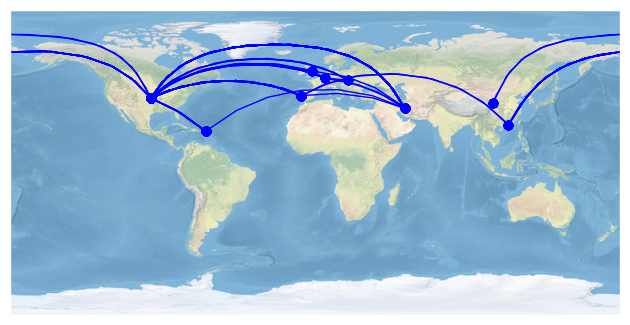

In [ ]:
for c in connections:
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.stock_img()

    for i in range(len(c)-1):
        start = c[i]
        stop = c[i+1]
        plt.plot([start['lon'], stop['lon']], [start['lat'],
        stop['lat']], color='blue', linewidth=1, marker='o',
        transform=ccrs.Geodetic())
    plt.show()

## Simple Classifier (Logistic Regression)

In [ ]:
df_clean = df[['user', 'dst_port', 'country', 'anomaly']]
df_clean.head()

user,dst_port,country,anomaly
str,i64,str,i64
"""0028e812""",443,"""United States""",0
"""0028e812""",443,"""United States""",0
"""0028e812""",443,"""United States""",0
"""0028e812""",443,"""United States""",0
"""0028e812""",443,"""United States""",0


### Domain Specific Encoding

The communications ports were grouped together into classes (for known ports below 1024) and adjusted accordingly.
Regarding the countries (that are aligned with ASN entity), they are ranked together based on proximity.

In [ ]:
df_unique_user = df.select(pl.col('user').unique(maintain_order=True)).with_row_index(name='user_enc')
df_clean = df_clean.join(df_unique_user, on='user')
df_clean = df_clean.drop('user')
df_clean = df_clean.rename({'user_enc': 'user'})
df_clean = df_clean.with_columns(pl.col('dst_port').replace_strict(map_dst_ports, default=100).alias('dst_port'))
df_clean = df_clean.with_columns(pl.col('country').replace_strict(map_contries, default=1000).alias('country'))
df_clean.head()

dst_port,country,anomaly,user
i64,i64,i64,u32
30,205,0,0
30,205,0,0
30,205,0,0
30,205,0,0
30,205,0,0


### Full Dataset

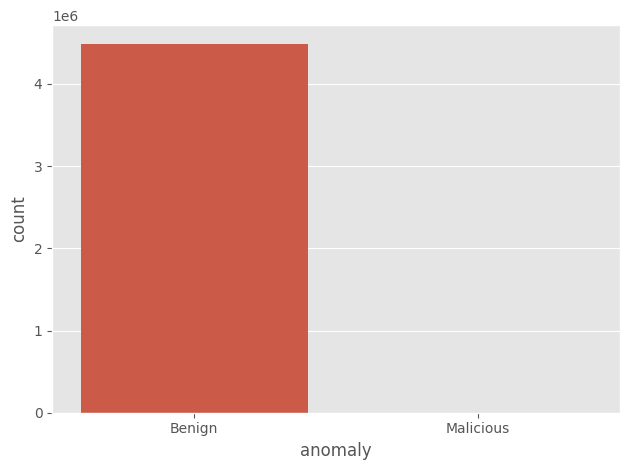

In [ ]:
df_malicious = df_clean.filter(pl.col('anomaly') == 1)
df_benign    = df_clean.filter(pl.col('anomaly') == 0)

df_count = pl.DataFrame({'anomaly': ['Benign', 'Malicious'], 'count': [df_benign.shape[0], df_malicious.shape[0]]})
sns.barplot(x='anomaly', y='count', hue='anomaly', data=df_count)
plt.show()

In [ ]:
Y = df_clean['anomaly']
X = df_clean.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
clf = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

              precision    recall  f1-score   support

      Benign       1.00      0.86      0.93   1347295
   Malicious       0.00      0.69      0.00       280

    accuracy                           0.86   1347575
   macro avg       0.50      0.78      0.46   1347575
weighted avg       1.00      0.86      0.93   1347575



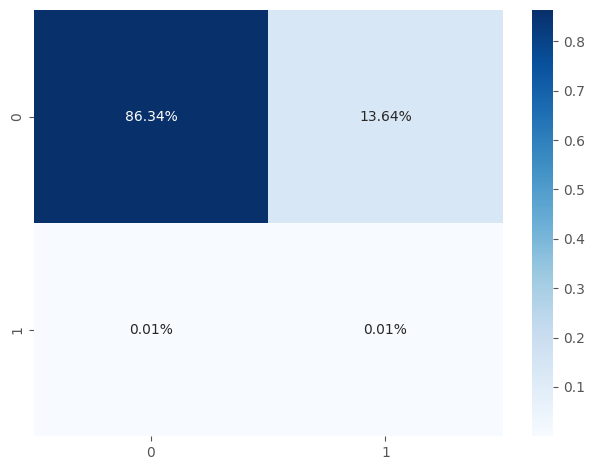

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

### Downsample Dataset

In [ ]:
df_malicious = df_clean.filter(pl.col('anomaly') == 1)
df_benign    = df_clean.filter(pl.col('anomaly') == 0)

df_benign_downsample = resample(df_benign, replace=True,
n_samples=len(df_malicious), random_state=42)

df_downsampled = pl.concat([df_malicious, df_benign_downsample])

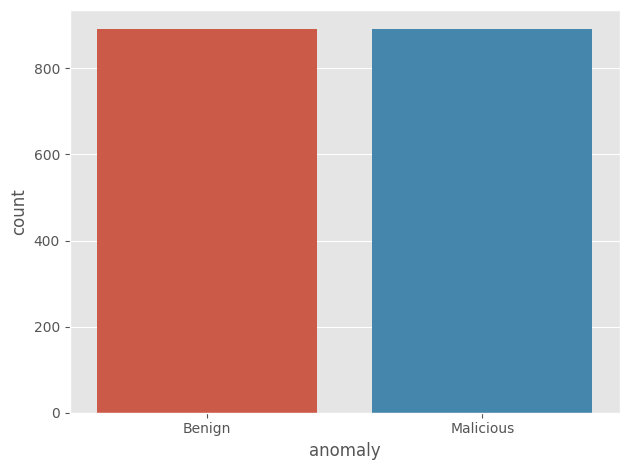

In [ ]:
df_downsampled_malicious = df_downsampled.filter(pl.col('anomaly') == 1)
df_downsampled_benign    = df_downsampled.filter(pl.col('anomaly') == 0)

df_count = pl.DataFrame({'anomaly': ['Benign', 'Malicious'], 'count': [df_downsampled_benign.shape[0], df_downsampled_malicious.shape[0]]})
sns.barplot(x='anomaly', y='count', hue='anomaly', data=df_count)
plt.show()

In [ ]:
Y = df_downsampled['anomaly']
X = df_downsampled.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
clf = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

              precision    recall  f1-score   support

      Benign       0.72      0.86      0.78       273
   Malicious       0.82      0.65      0.72       262

    accuracy                           0.76       535
   macro avg       0.77      0.75      0.75       535
weighted avg       0.77      0.76      0.75       535



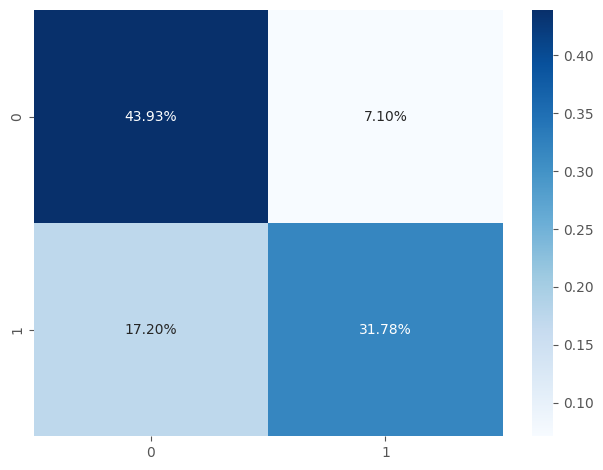

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

## Packet Flows

In [ ]:
def dataframe_shift(df, columns, windows):
    for i in range(1, windows):
        df = df.with_columns((pl.col(columns).shift(i)).name.prefix(f'prev_{i}_'))
    return df.drop_nulls()

In [ ]:
window = 5
df_users = df_clean.partition_by(by='user')
for i in range(len(df_users)):
    df_aux = df_users[i]
    df_users[i] = dataframe_shift(df_aux, columns=['dst_port', 'country'], windows=window)
df_clean_roll = pl.concat(df_users)
df_clean_roll.head()

dst_port,country,anomaly,user,prev_1_dst_port,prev_1_country,prev_2_dst_port,prev_2_country,prev_3_dst_port,prev_3_country,prev_4_dst_port,prev_4_country
i64,i64,i64,u32,i64,i64,i64,i64,i64,i64,i64,i64
30,205,0,0,30,205,30,205,30,205,30,205
30,205,0,0,30,205,30,205,30,205,30,205
30,205,0,0,30,205,30,205,30,205,30,205
30,205,0,0,30,205,30,205,30,205,30,205
30,205,0,0,30,205,30,205,30,205,30,205


### Full Dataset

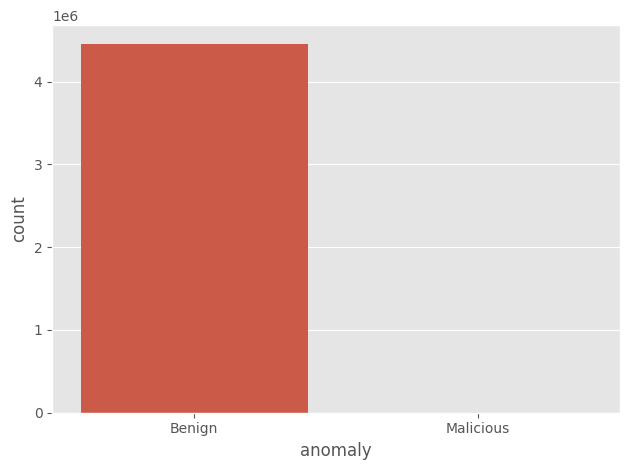

In [ ]:
df_roll_malicious = df_clean_roll.filter(pl.col('anomaly') == 1)
df_roll_benign    = df_clean_roll.filter(pl.col('anomaly') == 0)

df_count = pl.DataFrame({'anomaly': ['Benign', 'Malicious'], 'count': [df_roll_benign.shape[0], df_roll_malicious.shape[0]]})
sns.barplot(x='anomaly', y='count', hue='anomaly', data=df_count)
plt.show()

In [ ]:
Y = df_clean['anomaly']
X = df_clean.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
clf = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

              precision    recall  f1-score   support

      Benign       1.00      0.86      0.93   1347295
   Malicious       0.00      0.69      0.00       280

    accuracy                           0.86   1347575
   macro avg       0.50      0.78      0.46   1347575
weighted avg       1.00      0.86      0.93   1347575



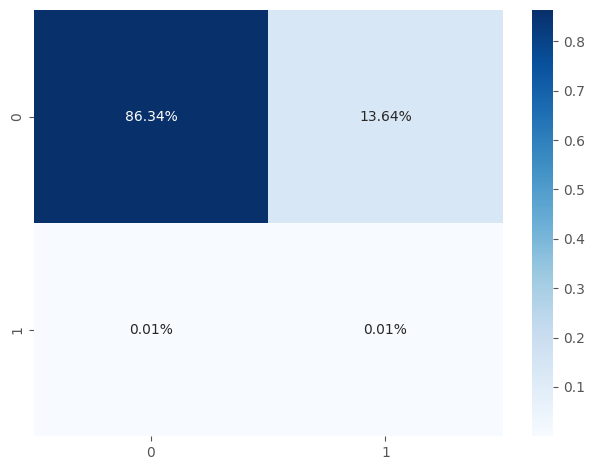

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

### Downsample Dataset

In [ ]:
df_malicious = df_clean_roll.filter(pl.col('anomaly') == 1)
df_benign    = df_clean_roll.filter(pl.col('anomaly') == 0)

df_benign_downsample = resample(df_benign, replace=True,
n_samples=len(df_malicious), random_state=42)

df_downsampled = pl.concat([df_malicious, df_benign_downsample])

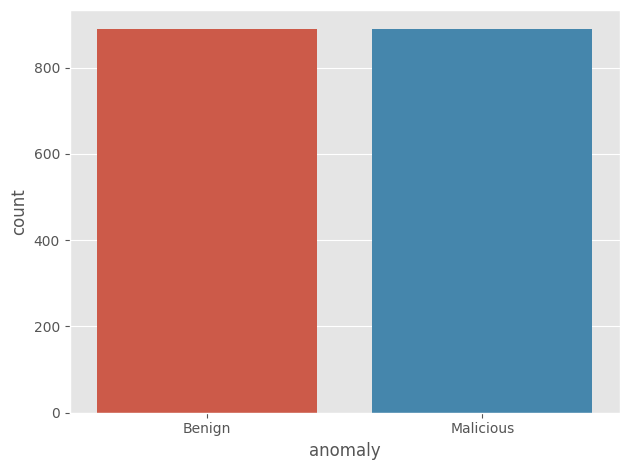

In [ ]:
df_roll_downsampled_malicious = df_downsampled.filter(pl.col('anomaly') == 1)
df_roll_downsampled_benign    = df_downsampled.filter(pl.col('anomaly') == 0)

df_count = pl.DataFrame({'anomaly': ['Benign', 'Malicious'], 'count': [df_roll_downsampled_benign.shape[0], df_roll_downsampled_malicious.shape[0]]})
sns.barplot(x='anomaly', y='count', hue='anomaly', data=df_count)
plt.show()

In [ ]:
Y = df_downsampled['anomaly']
X = df_downsampled.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
clf = LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))

              precision    recall  f1-score   support

      Benign       0.73      0.86      0.79       276
   Malicious       0.82      0.65      0.72       258

    accuracy                           0.76       534
   macro avg       0.77      0.76      0.76       534
weighted avg       0.77      0.76      0.76       534



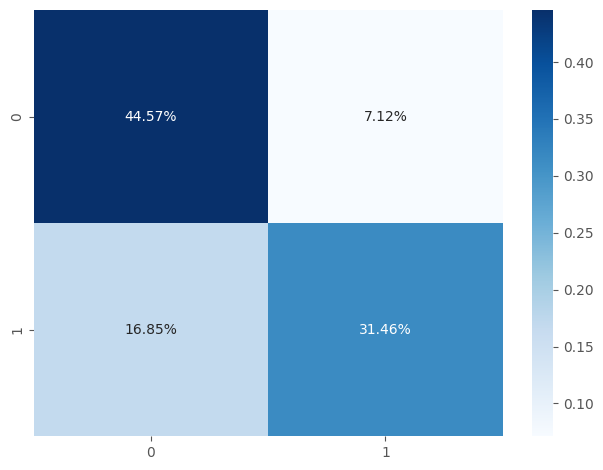

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.show()

## Outlier Detection Data Preprocessing

In [ ]:
df_clean_roll_malicious = df_clean_roll.filter(pl.col('anomaly') == 1)
df_clean_roll_benign    = df_clean_roll.filter(pl.col('anomaly') == 0)

Y = df_clean_roll_benign['anomaly']
X = df_clean_roll_benign.drop(['anomaly'])

k=3

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=df_clean_roll_malicious.shape[0]*k, random_state=42)

# Append the anomalies to the test
y_test = pl.concat([y_test, df_clean_roll_malicious['anomaly']])
X_test = pl.concat([X_test, df_clean_roll_malicious.drop(['anomaly'])])

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
X_train, X_validation = train_test_split(X_train, test_size=0.2, random_state=42)

## Traditional Outlier Detection

In [ ]:
clf = IsolationForest(n_estimators=100, n_jobs=-1, random_state=42)

clf.fit(X_train)
y_pred = clf.predict(X_test)
y_pred = np.clip(y_pred*-1, 0, 1)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2667
           1       0.50      0.79      0.61       889

    accuracy                           0.75      3556
   macro avg       0.71      0.76      0.71      3556
weighted avg       0.81      0.75      0.76      3556



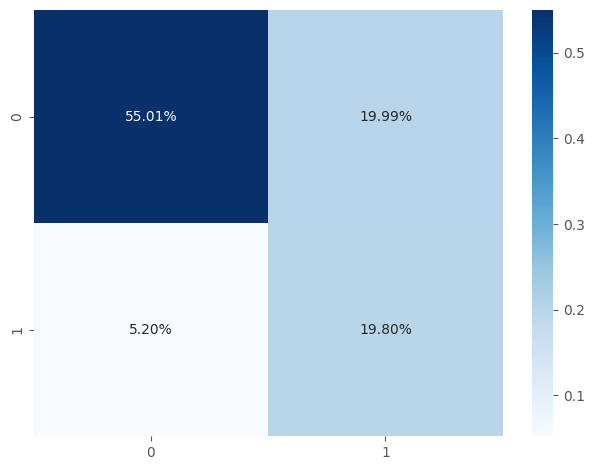

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.show()

## Clustering

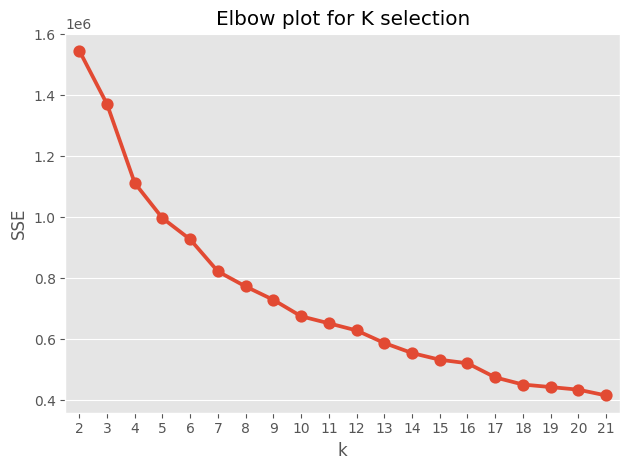

In [ ]:
sse = {}

for k in range(2, 22):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmeans.fit(X_train)
    sse[k] = kmeans.inertia_

plt.title('Elbow plot for K selection')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=10, n_init='auto', random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=10, random_state=42)

In [ ]:
from sklearn.metrics import matthews_corrcoef

def clustering_anomaly_detection(kmeans, X_train, X_test, y_test):
    distances_train = kmeans.transform(X_train)
    cluster_indices_train = kmeans.predict(X_train)
    mask = (cluster_indices_train[:, None] == np.arange(distances_train.shape[1]))
    distances_train[~mask] = 0

    dictionary = {i: column for i, column in enumerate(zip(*distances_train))}

    mean_distances = [sum(values) / len(values) for key, values in dictionary.items()]
    thresholds = np.array(mean_distances)

    distances_test = kmeans.transform(X_test)
    cluster_indices_test = kmeans.predict(X_test)
    mask = (cluster_indices_test[:, None] == np.arange(distances_test.shape[1]))
    distances_test[~mask] = 0

    min_limit = 0.01
    max_limit = 10
    inc = 0.01

    best_k = None
    best_mcc = None

    tk = np.arange(min_limit, max_limit, inc, dtype=float)
    print(f'{tk}')
    for k in tk:
        outliers = np.any(np.array(distances_test) > k*thresholds, axis=1)
        y_pred = [1 if v else 0 for v in outliers]
        mcc = matthews_corrcoef(y_test, y_pred)
        print(f'{k} -> {mcc}')
        if best_mcc is None:
            best_mcc = mcc
            best_k = k
        else:
            if mcc > best_mcc:
                best_mcc = mcc
                best_k = k

    print(f'{best_k} {best_mcc}')
    outliers = np.any(np.array(distances_test) > (best_k)*thresholds, axis=1)
    y_pred = [1 if v else 0 for v in outliers]

    return y_pred

In [ ]:
distances = kmeans.transform(X_test)
#print(f'{distances}')
cluster_indices = kmeans.predict(X_test)
mask = (cluster_indices[:, None] == np.arange(distances.shape[1]))

#print(f'{mask}')
distances[~mask] = 0
#print(f'{distances}')

dictionary = {i: column for i, column in enumerate(zip(*distances))}

mean_distances = [sum(values) / len(values) for key, values in dictionary.items()]
thresholds = np.array(mean_distances)

print(f'thresholds: {thresholds}')
k=3.0
outliers = np.any(np.array(distances) > k*thresholds, axis=1)
y_pred = [1 if v else 0 for v in outliers]
print(f'{outliers}')
print(f'{y_pred}')

thresholds: [0.03535178 0.05566539 0.01820235 0.03381139 0.03276031 0.08330496
 0.0436993  0.03737916 0.0130433  0.01064764]
[False False  True ...  True  True  True]
[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0

In [ ]:
y_pred_2 = clustering_anomaly_detection(kmeans, X_train, X_test, y_test)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12
 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25 1.26
 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39 1.4
 1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53 1.54
 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67 1.68
 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81 1.82
 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95 1.96
 1.97 1.

In [ ]:
print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.93      0.51      0.66      2667
           1       0.38      0.88      0.53       889

    accuracy                           0.60      3556
   macro avg       0.65      0.69      0.59      3556
weighted avg       0.79      0.60      0.63      3556

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      2667
           1       0.45      0.84      0.59       889

    accuracy                           0.71      3556
   macro avg       0.69      0.75      0.68      3556
weighted avg       0.81      0.71      0.73      3556



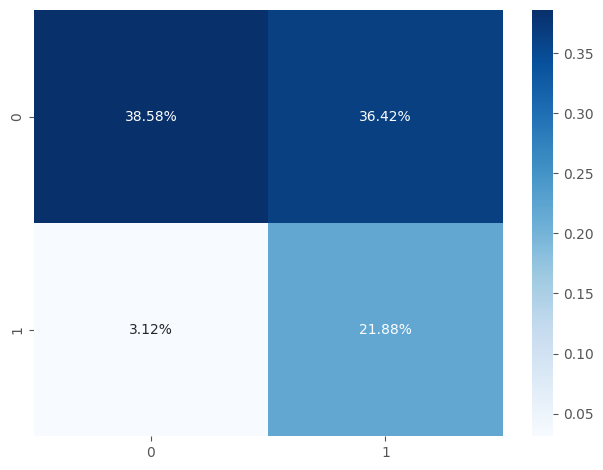

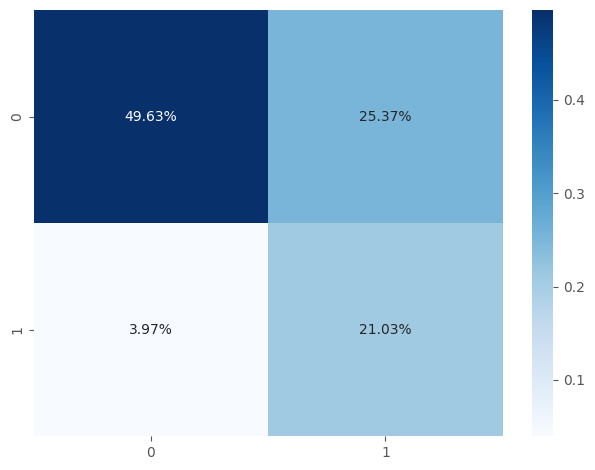

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.show()

cm = confusion_matrix(y_test, y_pred_2)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')
plt.show()

## AutoEncoder

In [ ]:
def isodata(array: np.ndarray) -> float:
    """
    Returns optimal threshold for dividing the sequence of values.

    Args:
        array (np.ndarray): numpy array with the values

    Returns:
        float: optimal threshold for dividing the sequence of values
    """
    median = np.median(array)
    previous_median = 0.0

    while median != previous_median:
        median_left = np.median(array[array <= median])
        median_right = np.median(array[array > median])

        previous_median = median
        median = (median_left+median_right) / 2.0

    return median

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    return 0.6745 * ad / mad

In [ ]:
def autoencoder_model(input_dim, latent_dim, layer_units, loss=keras.losses.Huber(delta=0.1), seed=42):
    keras.utils.set_random_seed(seed)

    input_layer = keras.layers.Input(shape=(input_dim,))
    x = input_layer

    # Encoder
    for units in layer_units:
        x = keras.layers.Dense(units, activation='elu', kernel_initializer='glorot_uniform')(x)

    # Bottleneck
    latent = keras.layers.Dense(latent_dim, activation='elu', kernel_initializer='glorot_uniform')(x)

    # Decoder
    x = latent
    for units in reversed(layer_units):
        x = keras.layers.Dense(units, activation='elu', kernel_initializer='glorot_uniform')(x)

    # Output layer (matches original notebook's 'linear')
    output_layer = keras.layers.Dense(input_dim, activation='linear')(x)

    autoencoder = keras.Model(inputs=input_layer, outputs=output_layer)

    # Compile with Adam optimizer as requested
    autoencoder.compile(optimizer=keras.optimizers.Adam(), loss=loss, metrics=['r2_score'])

    return autoencoder

In [ ]:
def objective(trial, X_train, X_test, y_test):
    # --- Hyperparameter Sampling ---
    input_dim = X_train.shape[1]
    # Number of hidden layers on the encoder side
    n_layers = trial.suggest_int('n_layers', 1, 3)
    # Size of the bottleneck layer
    bottleneck_dim = trial.suggest_int('bottleneck_dim', 2, 8, log=True)

    layer_units = []
    last_units = input_dim

    # Sample layer sizes for the encoder
    for i in range(n_layers):
        # Ensure units decrease and are larger than bottleneck
        min_units = bottleneck_dim * 2
        max_units = int(last_units / 1.5)

        if min_units > max_units:
            min_units = bottleneck_dim # fallback

        if min_units >= max_units:
            # Handle edge case where max_units is too small
            if max_units <= min_units:
                max_units = min_units + 2 # Ensure a small range
            units = trial.suggest_int(f'encoder_units_{i+1}', min_units, max_units)
        else:
            units = trial.suggest_int(f'encoder_units_{i+1}', min_units, max_units, log=True)

        layer_units.append(units)
        last_units = units

    # --- Model Building (Dynamic) ---
    # Sticking to user's request: ELU activation and Adam optimizer

    autoencoder = autoencoder_model(input_dim, bottleneck_dim, layer_units)

    # --- Model Training ---
    autoencoder.fit(X_train, X_train,
                    epochs=30, # Fixed epochs for fair comparison
                    batch_size=4096,
                    validation_data=(X_validation, X_validation),
                    verbose=0,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             patience=5,
                                                             restore_best_weights=True)])

    # --- Evaluation (as per notebook) ---
    reconstructions = autoencoder.predict(X_test, verbose=0)

    # Use Mean Absolute Error (MAE) as in the notebook's evaluation cell
    mae = np.mean(np.abs(X_test - reconstructions), axis=1)

    # Use the notebook's ISODATA threshold rule
    thr = isodata(mae)
    y_pred = (mae > thr).astype(int)

    # --- Metric (MCC) ---
    mcc = matthews_corrcoef(y_test, y_pred)

    return mcc

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')
Y = df_clean['anomaly']
X = df_clean.drop(['anomaly'])

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(),
test_size=0.3, random_state=42, stratify=Y)

# Need to remove malicions samples
X_train = X_train[y_train == 0]
X_validation = X_test[y_test == 0]

print(X_train.dtype)

# undersample the Test part
X_test, y_test = undersample.fit_resample(X_test, y_test)

print(f'Training data {len(y_train)} Testing data {(len(y_test))}')

int64
Training data 3144341 Testing data 534


In [ ]:
print("--- Starting Optuna Optimization ---")

# Create a study object and specify the direction as 'maximize'
study = optuna.create_study(direction='maximize')

# Start the optimization
# n_trials=30 is a good starting point, can be adjusted
study.optimize(lambda trial: objective(trial, X_train, X_test, y_test), n_trials=30)

print("--- Optimization Finished ---")

In [ ]:
print("--- Starting Optuna Optimization ---")

# Create a study object and specify the direction as 'maximize'
study = optuna.create_study(direction='maximize')

# Start the optimization
# n_trials=30 is a good starting point, can be adjusted
study.optimize(objective, n_trials=30)

print("--- Optimization Finished ---")

In [ ]:
# data dimensions // hyperparameters
input_dim = X_train.shape[1]
latent_dim = 4

autoencoder = autoencoder_model(input_dim, latent_dim)
autoencoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135 (540.00 B)

 Trainable params: 135 (540.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 4096
history = autoencoder.fit(X_train, X_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
validation_data=(X_validation, X_validation), verbose=0, callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True), TqdmCallback(verbose=0)])

0epoch [00:00, ?epoch/s]

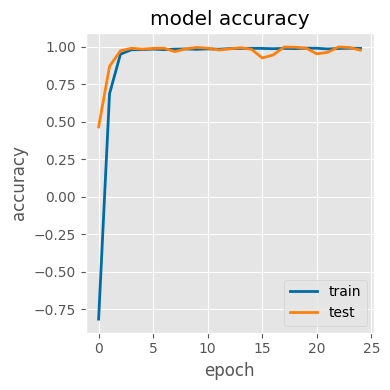

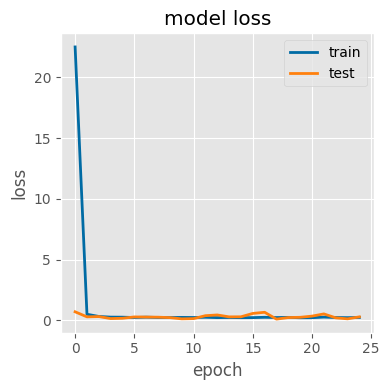

In [ ]:
# summarize history for accuracy
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
mae = np.mean(np.abs(X_test - reconstructions), axis=1)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


0.5% anomaly


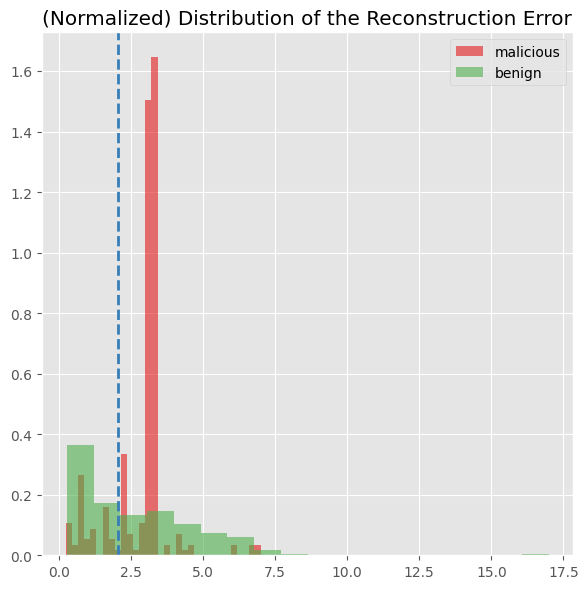

In [ ]:
malicious = mae[y_test==1]
benign    = mae[y_test==0]

print(f'{len(malicious)/(len(benign)+len(malicious)):.2}% anomaly')

thr = isodata(mae)
#print(f'({name} {ae_name}) ISO-Data Thr: {thr}')
y_pred = mae > thr

bin_edges_malicious = np.histogram_bin_edges(malicious, bins='auto')
bin_edges_benign = np.histogram_bin_edges(benign, bins='auto')

fig, ax = plt.subplots(figsize=(6,6))


ax.hist(malicious, bins=bin_edges_malicious, density=True, label="malicious", alpha=.6, color=colormap[7])
ax.hist(benign, bins=bin_edges_benign, density=True, label="benign", alpha=.6, color=colormap[2])
plt.axvline(x = thr, color = colormap[0], linestyle='--')
#print(f'{bin_edges_malicious}/{bin_edges_benign}')
plt.title("(Normalized) Distribution of the Reconstruction Error")
plt.legend()
plt.show()

In [ ]:
mcc = matthews_corrcoef(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'MCC: {mcc} F1-Score {f1}')

MCC: 0.3505781338488767 F1-Score 0.7136


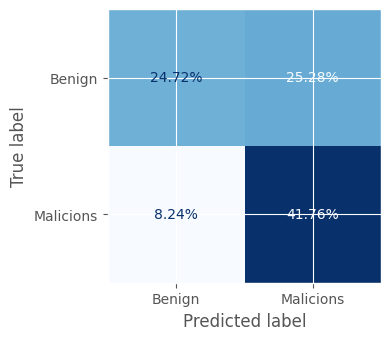

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_matrix/np.sum(cf_matrix),
display_labels = ['Benign', 'Malicions'])
cm_display.plot(values_format='.2%', colorbar=False, cmap='Blues')
plt.show()